# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
fto = '/storage/experiments/2021/03_REFLECT3/AirdosCvetsiNaITl_9c/DATALOG.TXT' #  File to Open
#fto = '/storage/experiments/2021/0609_bourka_sobeslav/GEODOS/BF/DATALOG.TXT' #  File to Open
#fto = '/storage/experiments/2021/0605_bourka_radosovice/GEODOS/BF/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/0803_bourka_votice/geodos/DATALOG.TXT'
fto = '/storage/experiments/2021/0726_bourka_zabori/geodos/DATALOG.TXT'
fto = '/storage/experiments/2021/0725_bourka_ratmirov/geodos/DATALOG.TXT'
fto = '/storage/stations/Polednik/geodos/13/210720/DATALOG.TXT'
fto = '/storage/stations/Polednik/geodos/10/210812/DATALOG.TXT'
#fto = '/storage/stations/Polednik/geodos/13/210720/test.txt'

l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

#!!!
#df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a20091e412a000a0000010
f.v.:  51832f3
0         GEO2
1         GEO2
198983    GEO2
229800    GEO2
352099    GEO2
Name: 1, dtype: object
399876
352099


## Fill position and time by GPS NMEA records

In [103]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

if (len(df.loc[df[0]=='$GNRMC']) > 0):
    print('Warning - Multiconstellation appears')
    print('Use next cell.')
    raise StopExecution
#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


Warning - Multoconstellation appear
Use next cell.


## Fill position and time by NMEA records in case of multiconstellation support

In [3]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
# is valid GPS time?
df.loc[(df[0]=='$GPGSV'),'valid_gps_time'] = False
df.loc[(df[0]=='$GNRMC'),'valid_gps_time'] = True
df['valid_gps_time'] = df['valid_gps_time'].fillna(method='ffill')
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['valid_gps_time']==True),1]) * 1000

df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GNGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,496,497,498,499,valid_gps_time,alt,lat,lon,meas,UTC
2,$GNVTG,GEO2,T,1290c00806a20091e412a000a0000010,M,0.059,N,0.109,K,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,$GNGSA,A,3,23,05,18,29,05,3.66,465.4,...,NaN,NaN,NaN,NaN,NaN,465.4,NaN,NaN,NaN,NaT
5,$GNGSA,A,3,69,05,18,29,05,3.66,465.4,...,NaN,NaN,NaN,NaN,NaN,465.4,NaN,NaN,NaN,NaT
8,$GLGSV,1,1,02,69,07,112,33,85,34,...,NaN,NaN,NaN,NaN,False,465.4,NaN,NaN,NaN,NaT
9,$GNGLL,4915.63881,N,01441.50779,E,090133.00,A,A,85,34,...,NaN,NaN,NaN,NaN,False,465.4,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399871,$HITS,4,76902,42,86293,31,98257,52,123643,10,...,NaN,NaN,NaN,NaN,True,1331.0,49.0641,13.395068,21545,2021-08-12 14:22:22.770
399872,$HIST,21546,355029.96,87340.25,21.69,3.66,13,404,889,13775,...,NaN,NaN,NaN,NaN,True,1331.0,49.0641,13.395068,21546,2021-08-12 14:22:39.330
399873,$HITS,5,94141,60,108169,13,117611,29,133708,37,...,NaN,NaN,NaN,NaN,True,1331.0,49.0641,13.395068,21546,2021-08-12 14:22:39.330
399874,$HIST,21547,355046.52,87335.75,21.38,3.66,16,404,889,6367,...,NaN,NaN,NaN,NaN,True,1331.0,49.0641,13.395068,21547,2021-08-12 14:22:55.890


## Add individual events to histogram

In [4]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:270].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)
hits = df.loc[df[0]=='$HITS'].copy()
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits.set_index('meas', inplace=True)


In [149]:
for index, row in hits.iterrows():
    for j in range(2,2+row[1]*2,2):
        hist.loc[index,int(row[j+1])+3] += 1


ValueError: Must have equal len keys and value when setting with an iterable

## Plot Flux

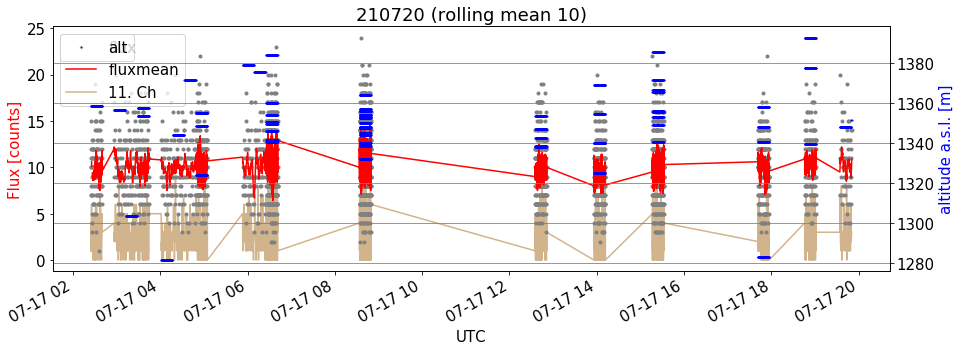

In [75]:
NOISE_LEVEL = 11
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', linestyle='none', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



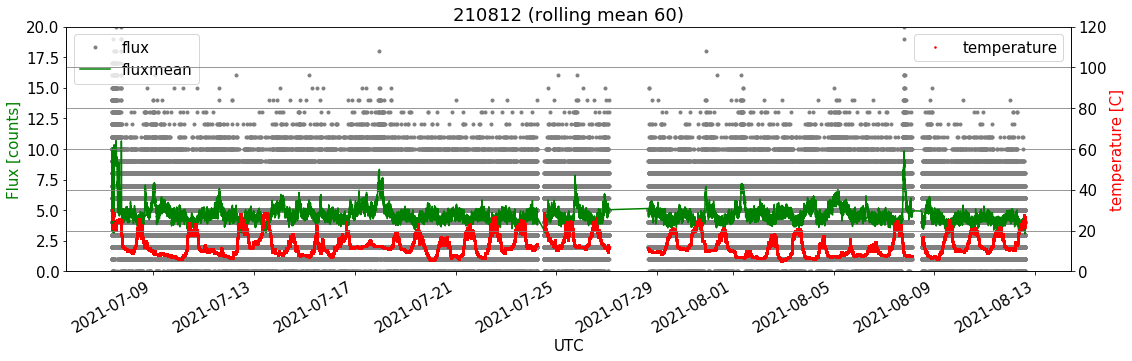

In [5]:
NOISE_LEVEL = 13
LAST_CHANNEL = 270
WINDOW = 60

plt.figure(figsize=(18,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 20:00:00']
#xx = xx.loc['2021-8-7 00:00:00':'2021-8-8 00:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='green')
#!!!(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([0,20])
#plt.xlim(['2021-7-7 00:00:00','2021-8-13 00:00:00'])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='green')
plt.legend(loc=2)

ax = plt.twinx()

xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid', zorder=1)
plt.ylabel('temperature [C]', color='red')
plt.ylim([0,120])

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



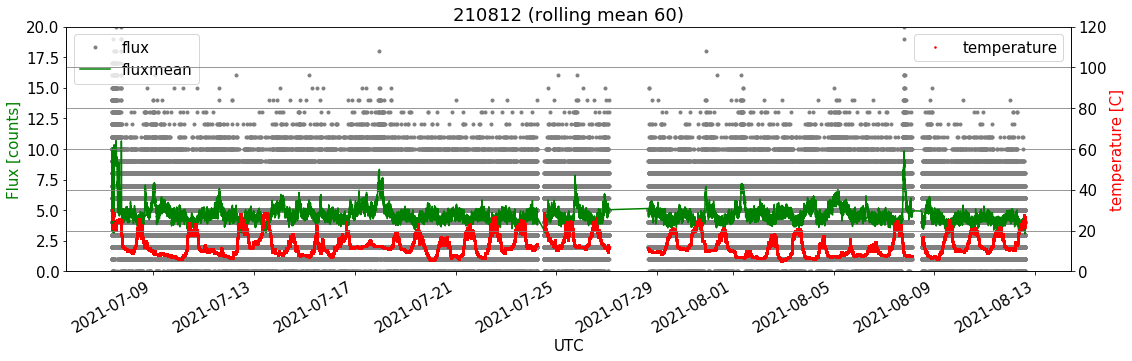

In [8]:
NOISE_LEVEL = 13
LAST_CHANNEL = 270
WINDOW = 60

plt.figure(figsize=(18,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 20:00:00']
#xx = xx.loc['2021-8-7 00:00:00':'2021-8-8 00:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='green')
#!!!(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([0,20])
#plt.xlim(['2021-7-7 00:00:00','2021-8-13 00:00:00'])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='green')
plt.legend(loc=2)

ax = plt.twinx()

xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid', zorder=1)
plt.ylabel('temperature [C]', color='red')
plt.ylim([0,120])

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



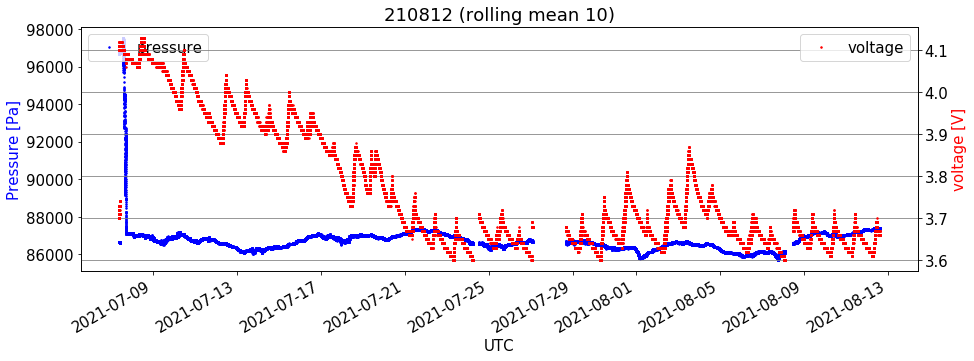

In [7]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[5].plot(c='red', label='voltage', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('voltage [V]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



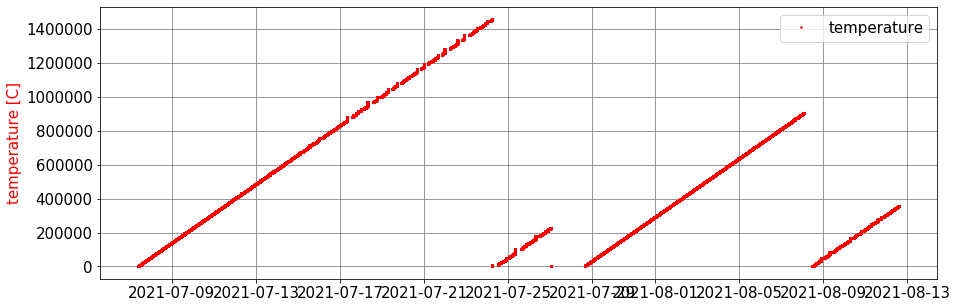

In [40]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']

#plt.ylim([0,14000])
plt.plot(xx.index, xx[2], c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


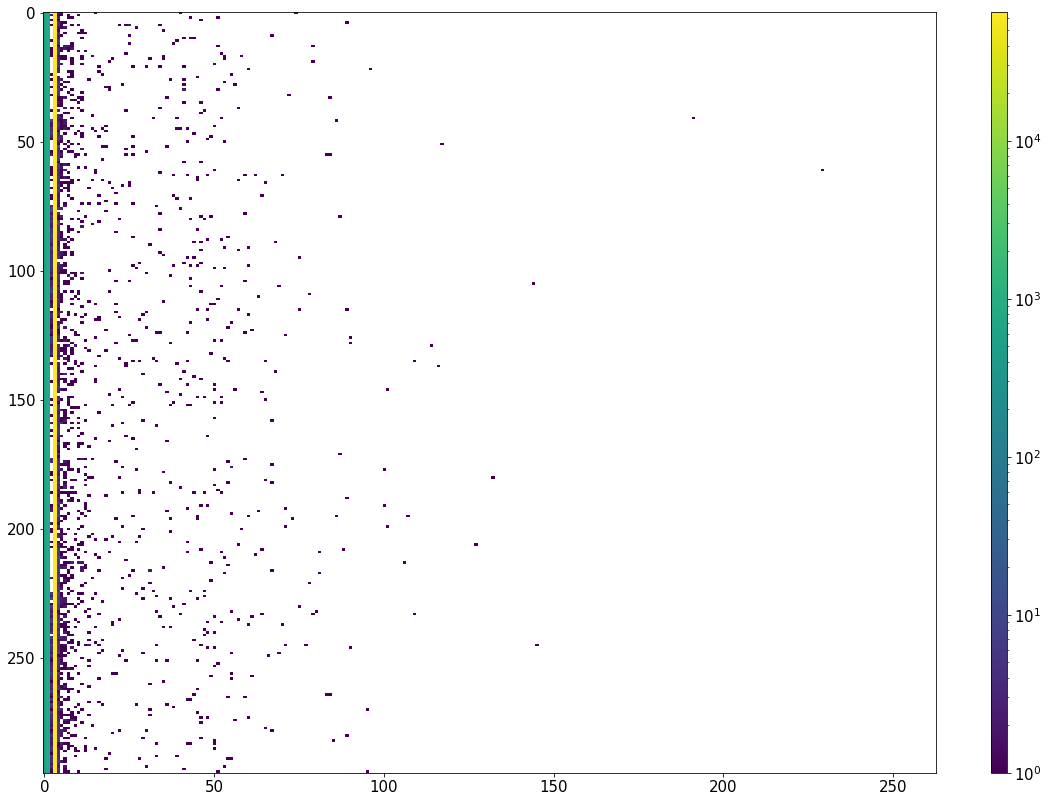

In [29]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((hist.iloc[:,7:270]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

In [6]:

#hist['2021-7-7 00:00:00':].iloc[:,7:]
xx

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-07-07 09:01:50.200,$HIST,0,82.50,96670.00,21.00,4.11,-38,965,965,28833,...,0,0,0,NaN,466.6,49.26064,14.691823,2021-07-07 09:01:50.200,17.0,NaN
2021-07-07 09:02:05.990,$HIST,1,98.29,96665.00,21.00,4.11,-22,965,965,26205,...,0,0,0,NaN,466.6,49.26064,14.691823,2021-07-07 09:02:05.990,13.0,NaN
2021-07-07 09:02:22.230,$HIST,2,114.53,96671.50,21.06,4.11,-17,965,965,24634,...,0,0,0,NaN,466.6,49.26064,14.691823,2021-07-07 09:02:22.230,16.0,NaN
2021-07-07 09:02:38.440,$HIST,3,130.74,96671.25,21.06,4.11,-15,965,965,29804,...,0,0,0,NaN,466.6,49.26064,14.691823,2021-07-07 09:02:38.440,14.0,NaN
2021-07-07 09:02:54.660,$HIST,4,146.96,96672.50,21.06,4.11,-15,965,965,21863,...,0,0,0,NaN,466.6,49.26064,14.691823,2021-07-07 09:02:54.660,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-12 14:21:49.660,$HIST,21543,354980.29,87398.50,22.56,3.66,3,404,889,7147,...,0,0,0,NaN,1331.0,49.06410,13.395068,2021-08-12 14:21:49.660,4.0,3.366667
2021-08-12 14:22:06.220,$HIST,21544,354996.85,87363.75,22.25,3.67,13,404,889,15814,...,0,0,0,NaN,1331.0,49.06410,13.395068,2021-08-12 14:22:06.220,6.0,3.450000
2021-08-12 14:22:22.770,$HIST,21545,355013.40,87343.00,22.00,3.66,18,404,889,8324,...,0,0,0,NaN,1331.0,49.06410,13.395068,2021-08-12 14:22:22.770,7.0,3.500000


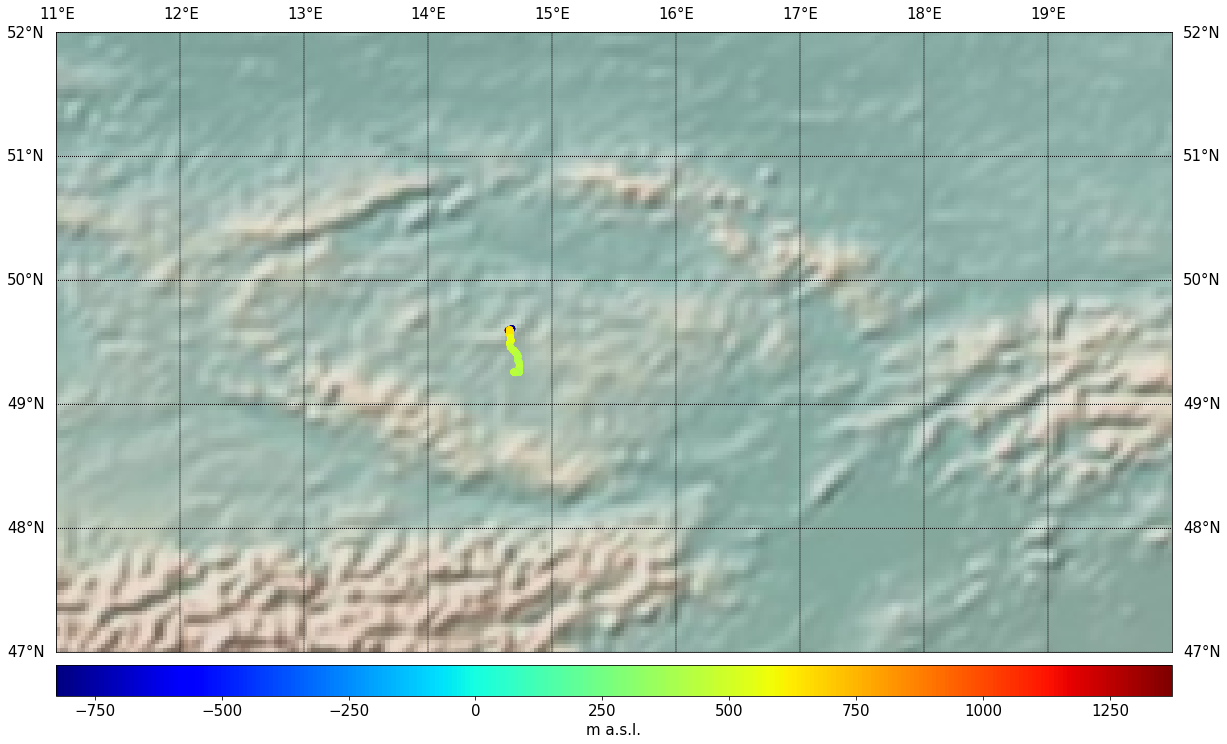

In [35]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(hist.lon.tolist(),hist.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


49.26026633333333   14.694009833333332


/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1626824.1330945592,6279945.7051741695,1644635.251621483,6293552.425013547&bboxSR=3395&imageSR=3395&size=1000,763&dpi=96&format=png32&transparent=true&f=image


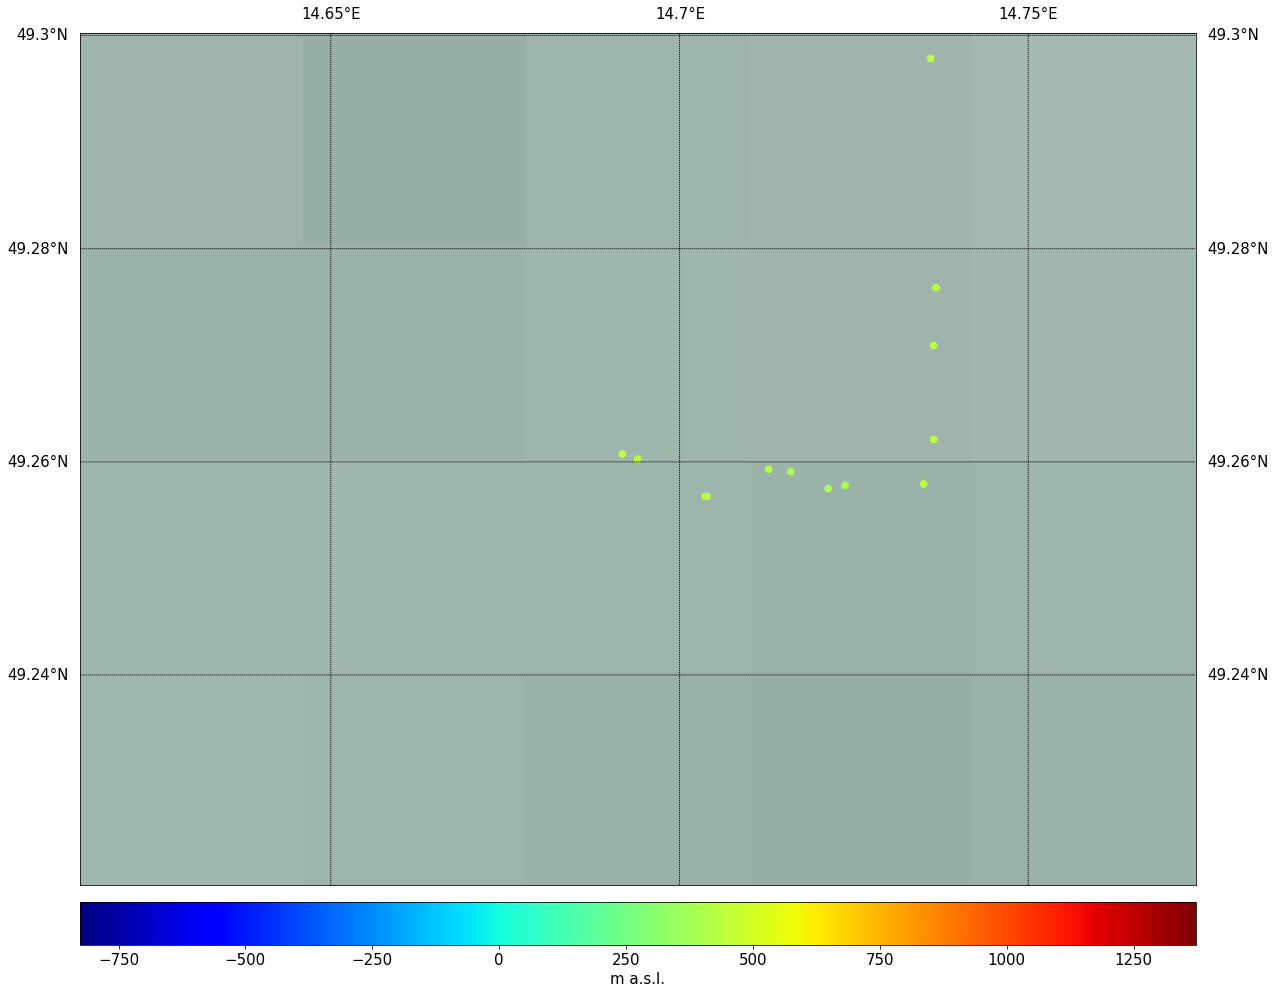

In [36]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

print(float(hist['lat'].tail(1)), " ", float(hist['lon'].tail(1)))
               
m = Basemap(llcrnrlon=hist['lon'][-1:]-0.08,llcrnrlat=hist['lat'][-1:]-0.04,urcrnrlon=hist['lon'][-1:]+0.08, urcrnrlat=hist['lat'][-1:]+0.04,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)

x, y = m(hist.lon.tolist(),hist.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


# Blitzortung

In [122]:
BLITZ_DIST 40
lat=49.0641069
lon=13.3951350
region=1
start=pd.to_datetime('2021-7-7 00:00:00')
end=pd.to_datetime('2021-8-10 00:00:00')
print(start, end, lat, lon)

### url for json data preparation
url=[]
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-1) )&(blitz['lat']<(lat+1) )]
blitz=blitz[(blitz['lon']>(lon-1) )&(blitz['lon']<(lon+1) )]
### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
#with pandas
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
#blitz['time']=blitz.index    
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)


2021-07-07 00:00:00 2021-08-13 00:00:00 49.0641069 13.395135
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/00.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/10.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/21/00.json
No data http://

NameError: name 'BLITZ_DIST' is not defined

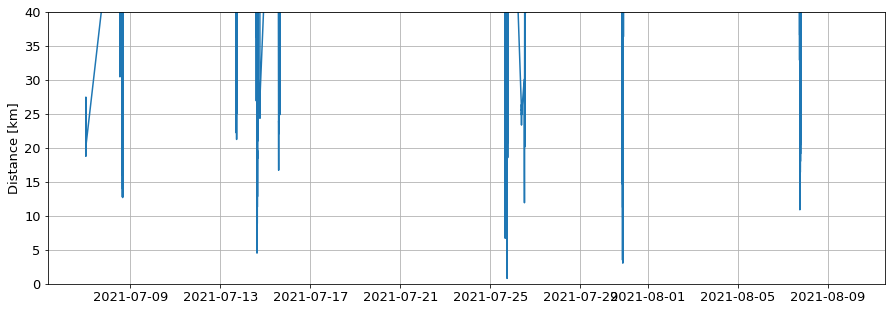

In [130]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

blitz['date'] = pd.to_datetime(blitz.index, unit='ns')

plt.plot(blitz['date'], blitz['km'])
plt.ylim([0,40])
plt.ylabel('Distance [km]')
plt.grid()

In [131]:
blitz

,lat,lon,mds,mcg,km,date
time,,,,,,
1625617843666792808,49.238639,13.336989,14413,83,19.884305,2021-07-07 00:30:43.666792808
1625618309135966168,49.242877,13.432483,14803,69,20.085078,2021-07-07 00:38:29.135966168
1625618309135973767,49.248611,13.434311,8418,104,20.735539,2021-07-07 00:38:29.135973767
1625618309135974650,49.248598,13.408572,11335,59,20.560299,2021-07-07 00:38:29.135974650
1625618309135978332,49.246985,13.404650,9488,59,20.369242,2021-07-07 00:38:29.135978332
...,...,...,...,...,...,...
1628445676610009477,49.982655,13.769022,8696,136,105.758822,2021-08-08 18:01:16.610009477
1628446730756666881,50.062732,14.101535,3003,150,122.304409,2021-08-08 18:18:50.756666881
1628446730756667055,50.058655,14.101610,6789,68,121.895224,2021-08-08 18:18:50.756667055


/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


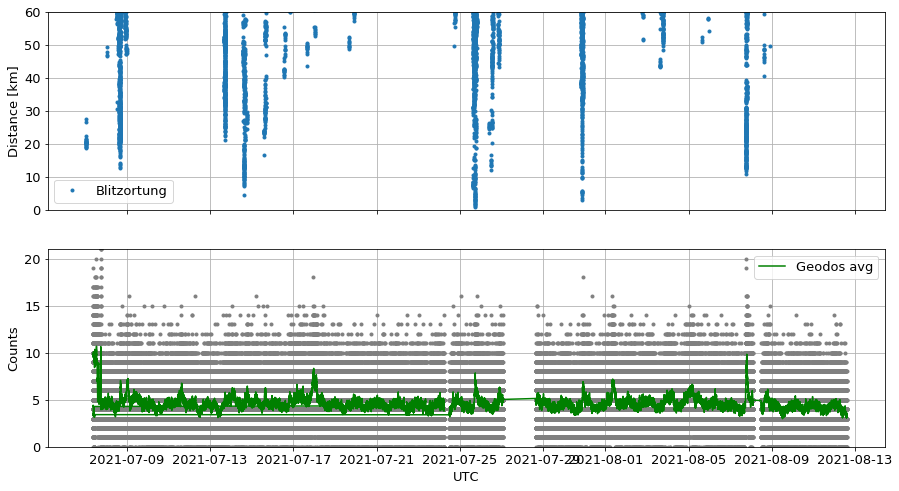

In [148]:
xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 14:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()


fig, (ax6, ax5) = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.')
ax5.plot(xx['fluxmean'], c='green', label='Geodos avg')
ax5.set_ylabel('Counts')
ax5.set_xlabel('UTC')
ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,60)
ax6.legend()
ax6.grid()


No handles with labels found to put in legend.


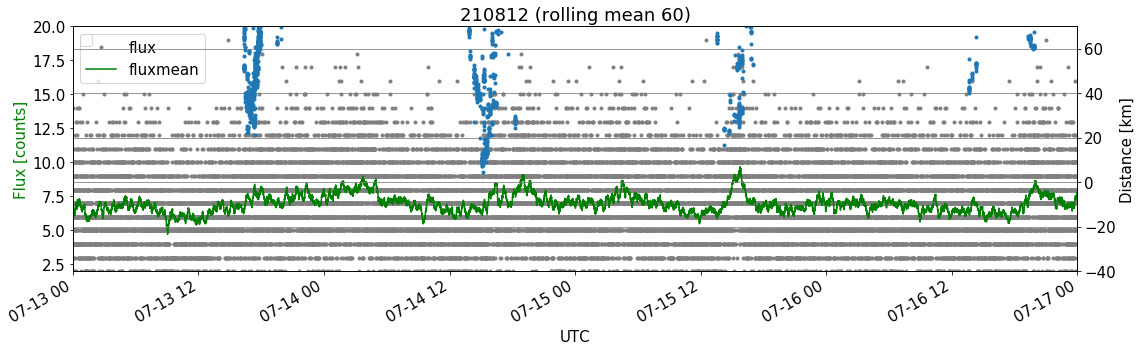

In [163]:
NOISE_LEVEL = 12
LAST_CHANNEL = 270
WINDOW = 60

plt.figure(figsize=(18,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 20:00:00']
#xx = xx.loc['2021-8-7 00:00:00':'2021-8-8 00:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='green')
#!!!(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([2,20])
plt.xlim(['2021-7-13 00:00:00','2021-7-17 00:00:00'])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='green')
plt.legend(loc=2)

ax = plt.twinx()

plt.plot(blitz['date'], blitz['km'], ls='', marker='.',)
plt.ylim([-40,70])
plt.ylabel('Distance [km]')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()

